In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
data_folder = "D:/korean-single-speaker-speech-dataset/kss"

with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [3]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [4]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [5]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [6]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [7]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

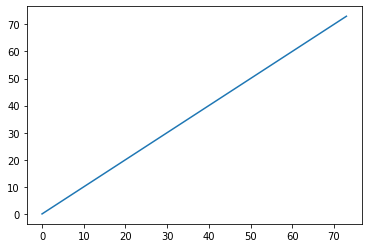

In [8]:
plt.plot(jamo_tokens)
plt.show()

In [9]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [10]:
# embedding_layer = nn.Embedding(len(jamo_tokens), 256)

# print(metadata[5031, 3])
# print(metadata[5031, 2])
# print(len(metadata[5031, 3]))

# input_token = tokenizer.word2num(metadata[5031, 3])
# input_tensor = torch.tensor(input_token)
# plt.imshow(embedding_layer(input_tensor).detach().numpy())

In [11]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [12]:
class Encoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(1, 128)
        
#       self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
        self.conv = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(128),
            torch.nn.ReLU())
        
        self.fc_before_gru = torch.nn.Linear(128 * 80, H)
        
        self.fc_2 = torch.nn.Linear(H, H)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = nn.Dropout(p=0.2)
        
        self.gru = nn.GRU(H, D_out, bidirectional=True, batch_first=True)
        self.relu_gru = torch.nn.ReLU()
        
        self.residual_gru_layers = nn.ModuleList([ResidualGRU(H, bidirectional=True) for i in range(3)])

    def forward(self, input_tensor):
            
        input_tensor_reshaped = input_tensor.view(input_tensor.shape[0], input_tensor.shape[1], input_tensor.shape[2], 1)
            
#         print("Tensor 1: {}".format(input_tensor_reshaped.shape))
            
        output_tensor = self.fc(input_tensor_reshaped)
        
#         print("Tensor 2: {}".format(output_tensor.shape))

        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        output_tensor = output_tensor.permute(0, 3, 1, 2)
        
#         print("Tensor 3: {}".format(output_tensor.shape))
        
        output_tensor = self.conv(output_tensor)
        
#         print("Tensor 4: {}".format(output_tensor.shape))
        
        output_tensor = output_tensor.permute(0, 2, 3, 1)
        
#         print("Tensor 5: {}".format(output_tensor.shape))
        
        t_shape = output_tensor.shape
        output_tensor = output_tensor.reshape(t_shape[0], t_shape[1], t_shape[2] * t_shape[3])
        
#         print("Tensor 6: {}".format(output_tensor.shape))
        
        output_tensor = self.fc_before_gru(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        output_tensor = self.relu_gru(output_tensor)
        
        for layer in self.residual_gru_layers:
            output_tensor = layer(output_tensor)
        
        output_tensor = self.fc_2(output_tensor)
        output_tensor = self.relu_2(output_tensor)
        output_tensor = self.dropout_2(output_tensor)
        
        return output_tensor
    
class Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(Decoder, self).__init__()
        self.H = H
        self.fc_embed = nn.Linear(256, 1024)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.2)
        
        self.gru = nn.GRU(2 * H, H, batch_first=True)
#         self.attention = AdditiveAttentionModule(D_out * 2)
        self.attention = MultiplicativeAttentionModule(D_out * 2)
    
        self.gru_1 = nn.GRU(2 * H, H, batch_first=True)
        self.gru_2 = nn.GRU(H, H, batch_first=True)
        self.gru_3 = nn.GRU(H, H, batch_first=True)
    
        self.fc = nn.Linear(512, 512)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
        self.fc2 = nn.Linear(512, 74)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, input_tensor, hidden_tensor, query, hidden_tensors):
#         print("Input tensor shape in Decoder: {}".format(input_tensor.shape))
#         print("Hidden_tensor shape in Decoder: {}".format(hidden_tensor.shape))
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
    
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))
#         print("Output Tensor Shape: {}".format(output_tensor.shape))
        
#         print("Hidden Tensor Shape: {}".format(hidden_tensor.shape))
        
        output_tensor, hidden_tensor = self.gru(output_tensor, hidden_tensor)
        
#         print("Hidden Tensor Shape: {}".format(hidden_tensor.shape))
#         print("Hidden_tensor shape in Decoder: {}".format(hidden_tensor.shape))
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))
    
        context_vector, alpha = self.attention(query, output_tensor)
        output_tensor = torch.cat([output_tensor, context_vector], dim=2)
#         print('output_tensor: {}'.format(output_tensor.shape))
#         print('output_tensor: {}'.format(context_vector.shape))

        hidden_tensor_1 = hidden_tensors[0]
        hidden_tensor_2 = hidden_tensors[1]
        hidden_tensor_3 = hidden_tensors[2]
        
        output_tensor, hidden_tensor_1 = self.gru_1(output_tensor, hidden_tensor_1)
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))
        output_tensor, hidden_tensor_2 = self.gru_2(output_tensor, hidden_tensor_2)
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))
        output_tensor, hidden_tensor_3 = self.gru_3(output_tensor, hidden_tensor_3)
#         print("Output tensor shape in Decoder: {}".format(output_tensor.shape))

        hidden_tensors = [hidden_tensor_1, hidden_tensor_2, hidden_tensor_3] 

        output_tensor = self.fc(output_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)        
        
        output_tensor = self.fc2(output_tensor)
        prediction_tensor = self.softmax(output_tensor)

        return prediction_tensor, hidden_tensor, context_vector, alpha, hidden_tensors

class AdditiveAttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(AdditiveAttentionModule, self).__init__()
        self.fc_alpha = nn.Linear(H, 1)
        self.W = nn.Linear(H, H)
        self.V = nn.Linear(H, H)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
        output_tensor = torch.tanh(torch.add(self.W(query), self.V(key)))
        e = self.fc_alpha(output_tensor)
        e_sig = self.sigmoid(e)
        alpha = self.softmax(e_sig).transpose(1, 2)
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha
    
class MultiplicativeAttentionModule(torch.nn.Module):
    def __init__(self, H):
        super(MultiplicativeAttentionModule, self).__init__()
#         self.W = nn.Linear(H, H)
#         self.V = nn.Linear(H, H)
#         self.sigmoid = nn.Sigmoid()t_shape
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, query, key):
#         output_tensor = torch.tanh(torch.bmm(self.W(query), self.V(key)))
#         print("Query shape: {}".format(query.shape))
#         print("Key shape: {}".format(key.shape))
        output_tensor = torch.bmm(query, key.transpose(1, 2))
#         print("Output shape: {}".format(output_tensor.shape))
#         e_sig = self.sigmoid(output_tensor)
        alpha = self.softmax(output_tensor).transpose(1, 2)
#         print('Alpha shape: {}'.format(alpha.shape))
        context_vector = torch.bmm(alpha, query)
        
        return context_vector, alpha

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H, D_out).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = Decoder(H, D_out).to(device)
#         self.encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=0.01)
#         self.decoder_optimizer = optim.SGD(self.decoder.parameters(), lr=0.01)
#         self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.01)
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.01)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.01)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.01)

        
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def train(self, input_tensor, ground_truth, loss_mask):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)
        decoder_hidden = encoded_tensor[:, -1, :].view(1, batch_size, self.H).contiguous()
#         decoder_hidden = encoded_tensor[:, -1, :].transpose(0, 1)
        
        pred_tensor_list = list()
        att_weight_list = list()
        
        loss = 0
        
        decoder_input = self.embedding_layer(torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).to(device)).view([batch_size, 1, -1])
        
#         print(encoded_tensor.shape)
#         print(decoder_hidden.shape)
#         print(decoder_input.shape)

        hidden_tensors = [torch.zeros(1, batch_size, 512).to(device), torch.zeros(1, batch_size, 512).to(device), torch.zeros(1, batch_size, 512).to(device)]
        
        for i in range(ground_truth.shape[1]):
            
            pred_tensor, decoder_hidden, context_vector, att_weight, hidden_tensors = self.decoder(decoder_input, decoder_hidden, encoded_tensor, hidden_tensors)
            pred_tensor_list.append(pred_tensor)
            att_weight_list.append(att_weight)
            
#             print('pred_tensor shape: {}'.format(pred_tensor.shape))
            truth = ground_truth[:, i]
            truth = truth.type(torch.cuda.LongTensor)
            
            loss += torch.dot(loss_mask[:, i], self.criterion(pred_tensor.view([batch_size, -1]), truth)) / batch_size
            decoder_input = self.embedding_layer(truth).view([batch_size, 1, -1])
#             pred_tensor_list.append(torch.tensor(tokenizer.num2vec(truth)).view(batch_size, 1, -1))
            
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        prediction = torch.cat(pred_tensor_list, dim=1)
        attention_matrix = torch.cat(att_weight_list, dim=1)
        
        return prediction, attention_matrix, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
    
net = Mel2SeqNet(80, 512, 256)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [14]:
# class Preloader():
#     def __init__(self, mel_path_list):
#         super(Preloader).__init__()
#         self.mel_path_list = mel_path_list
#         self.tensor_input_list = [None] * len(mel_path_list)
    
#     def load(self, i):
#         norm_log_mel_specgram = np.load(self.mel_path_list[i])
#         input_spectrogram = norm_log_mel_specgram.T
#         tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
#         self.tensor_input_list[i] = tensor_input
        
#     def get(self, i):
#         if type(self.tensor_input_list[i]) == type(None):
#             self.load(i)
#         return self.tensor_input_list[i]  
    
#     def get_batch(self):
        
#         return batched_tensor, indxes 

In [15]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 4
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        
        for order in range(count):
            batched_tensor[order, :tensor_size_list[order], :] = tensor_list[order]
#             print(ground_truth_size_list[order])
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask
        
#         return batched_tensor, ground_truth_tensor 

In [16]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [17]:
# preloader = Preloader(mel_path_list)
preloader = Batched_Preloader(mel_path_list, ground_truth_list, 16)

08-27 00:37:45
Calculated 50 Batches
Loss 50: 3.564182917277018
08-27 00:37:56


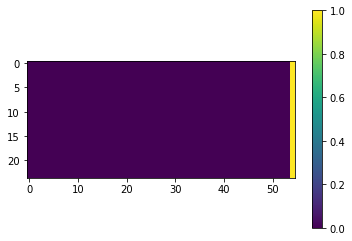

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
총을 쏘지 마세요.<eos>    
Mean Loss: 3.9277737887700397
----------------------------------------------------
08-27 00:37:57
Calculated 50 Batches
Loss 50: 3.5416463216145835
08-27 00:38:07


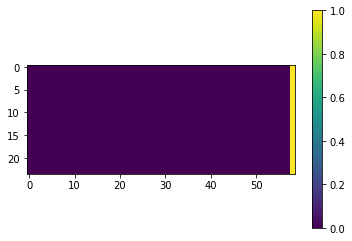

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이쪽으로 오세요.<eos>      
Mean Loss: 3.927863941510519
----------------------------------------------------
08-27 00:38:08
Calculated 50 Batches
Loss 50: 3.507841428120931
08-27 00:38:19


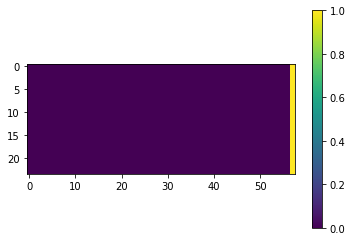

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
거기 그대로 있어.<eos>     
Mean Loss: 3.9273681316375733
----------------------------------------------------
08-27 00:38:19
Calculated 50 Batches
Loss 50: 3.5416460037231445
08-27 00:38:30


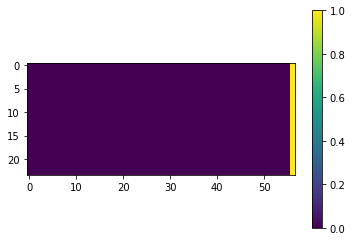

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
커피 맛이 어때?<eos>       
Mean Loss: 3.9253849210739133
----------------------------------------------------
08-27 00:38:31
Calculated 50 Batches
Loss 50: 3.586719512939453
08-27 00:38:41


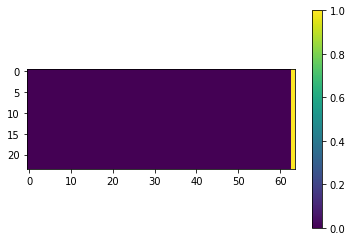

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
너는 할 수 있어.<eos>    
Mean Loss: 3.9284724140167238
----------------------------------------------------
08-27 00:38:42
Calculated 50 Batches
Loss 50: 3.5641825993855796
08-27 00:38:52


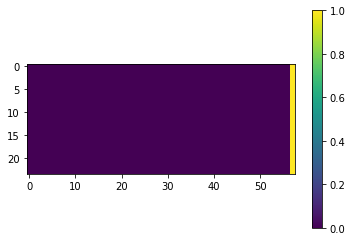

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
모레 시간 있어?<eos>      
Mean Loss: 3.9277287232081095
----------------------------------------------------
08-27 00:38:53
Calculated 50 Batches
Loss 50: 3.5416463216145835
08-27 00:39:04


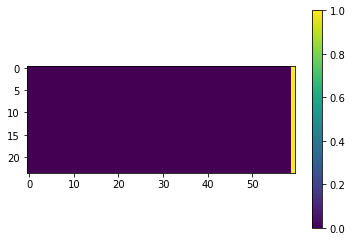

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
배고파 죽겠어요.<eos>     
Mean Loss: 3.927300503730774
----------------------------------------------------
08-27 00:39:04
Calculated 50 Batches
Loss 50: 3.552914301554362
08-27 00:39:15


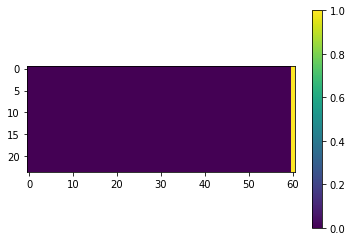

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
요가 너무 얇다.<eos>       
Mean Loss: 3.9312902185205827
----------------------------------------------------
08-27 00:39:15
Calculated 50 Batches
Loss 50: 3.636839825174083
08-27 00:39:26


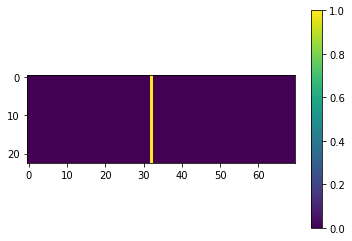

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
고기 먹으러 가자.<eos>    
Mean Loss: 3.933957992109246
----------------------------------------------------
08-27 00:39:27
Calculated 50 Batches
Loss 50: 3.552914301554362
08-27 00:39:38


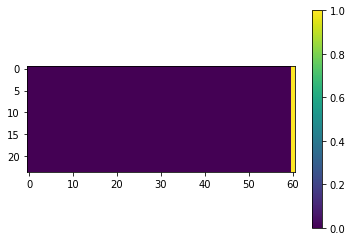

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
부모님께 효도해라.<eos>    
Mean Loss: 3.9269173933664963
----------------------------------------------------
08-27 00:39:38
Calculated 50 Batches
Loss 50: 3.609255790710449
08-27 00:39:49


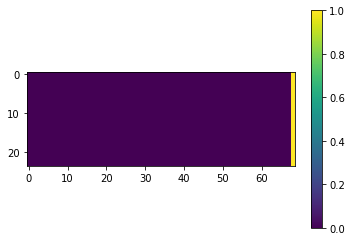

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
거기 그대로 있어.<eos>     
Mean Loss: 3.9277512353261312
----------------------------------------------------
08-27 00:39:50
Calculated 50 Batches
Loss 50: 3.6133233775263247
08-27 00:40:00


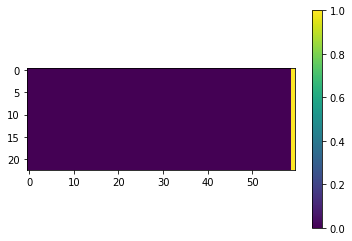

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
귀신 믿으세요?<eos>      
Mean Loss: 3.9296580357344255
----------------------------------------------------
08-27 00:40:01
Calculated 50 Batches
Loss 50: 3.636839825174083
08-27 00:40:11


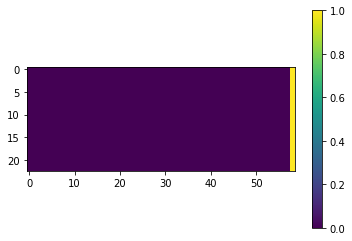

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
매주 엽서 보낼게.<eos>   
Mean Loss: 3.929564966008283
----------------------------------------------------
08-27 00:40:12
Calculated 50 Batches
Loss 50: 3.636839825174083
08-27 00:40:22


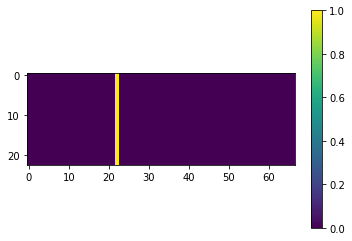

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는 억울해요.<eos>     
Mean Loss: 3.930917164609052
----------------------------------------------------
08-27 00:40:23
Calculated 50 Batches
Loss 50: 3.6133233775263247
08-27 00:40:34


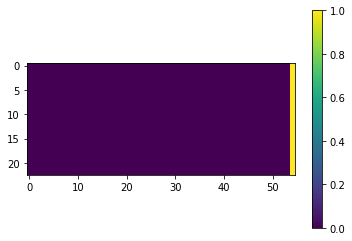

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
말대꾸하지 마라.<eos>     
Mean Loss: 3.9342172426970103
----------------------------------------------------
08-27 00:40:34
Calculated 50 Batches
Loss 50: 3.552914301554362
08-27 00:40:45


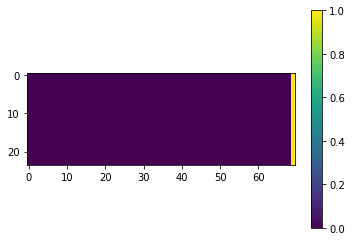

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
천천히 먹어라.<eos>      
Mean Loss: 3.9265117314656575
----------------------------------------------------
08-27 00:40:46
Calculated 50 Batches
Loss 50: 3.5979878107706704
08-27 00:40:57


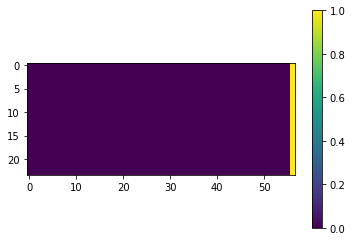

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
목말라 죽겠어.<eos>     
Mean Loss: 3.9306177086244545
----------------------------------------------------
08-27 00:40:57
Calculated 50 Batches
Loss 50: 3.8267357566139917
08-27 00:41:08


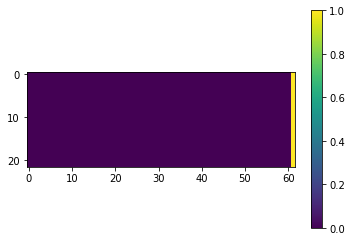

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
행복하게 살아라.<eos>  
Mean Loss: 3.932236082510515
----------------------------------------------------
08-27 00:41:09
Calculated 50 Batches
Loss 50: 3.4176953633626304
08-27 00:41:19


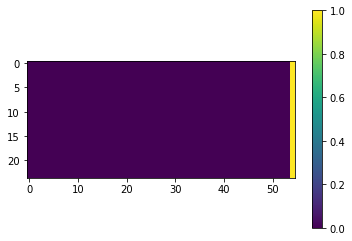

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
힘든 하루였어요.<eos>    
Mean Loss: 3.928472419420878
----------------------------------------------------
08-27 00:41:20
Calculated 50 Batches
Loss 50: 3.6133233775263247
08-27 00:41:30


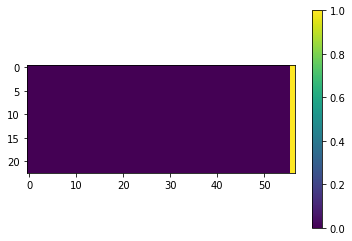

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
렌즈 끼셨어요?<eos>      
Mean Loss: 3.929387622017791
----------------------------------------------------
08-27 00:41:31
Calculated 50 Batches
Loss 50: 3.4514999389648438
08-27 00:41:42


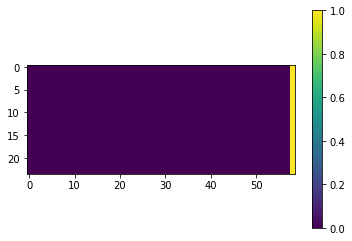

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
헛소리 그만해!<eos>       
Mean Loss: 3.926466691335042
----------------------------------------------------
08-27 00:41:42
Calculated 50 Batches
Loss 50: 3.660356272821841
08-27 00:41:53


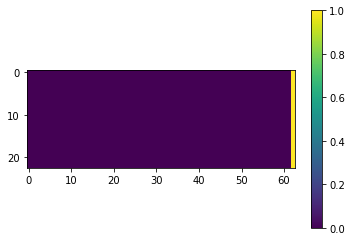

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는 억울해요.<eos>     
Mean Loss: 3.9305536528739378
----------------------------------------------------
08-27 00:41:54
Calculated 50 Batches
Loss 50: 3.5191094080607095
08-27 00:42:04


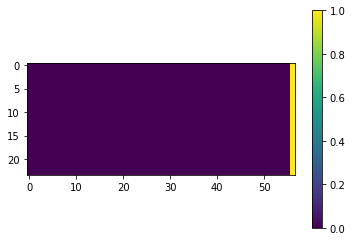

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
세월 참 빠르네요.<eos>    
Mean Loss: 3.92655679988861
----------------------------------------------------
08-27 00:42:05
Calculated 50 Batches
Loss 50: 3.3951587677001953
08-27 00:42:15


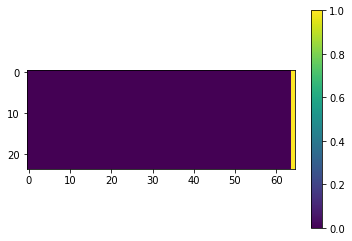

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
내 몸에서 손 떼.<eos>     
Mean Loss: 3.9277287368774423
----------------------------------------------------
08-27 00:42:16
Calculated 50 Batches
Loss 50: 3.575451215108236
08-27 00:42:27


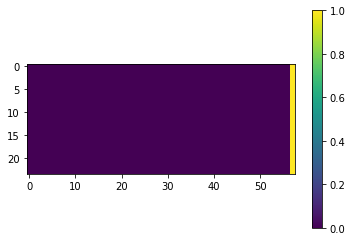

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
국이 좀 싱겁네.<eos>    
Mean Loss: 3.928878053029378
----------------------------------------------------
08-27 00:42:27
Calculated 50 Batches
Loss 50: 3.648598048997962
08-27 00:42:38


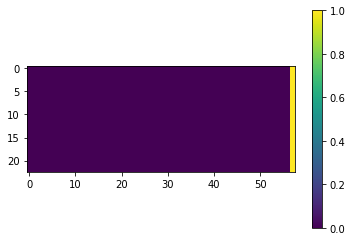

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
온몸이 쑤셔요.<eos>      
Mean Loss: 3.930611473677814
----------------------------------------------------
08-27 00:42:38
Calculated 50 Batches
Loss 50: 3.507841110229492
08-27 00:42:49


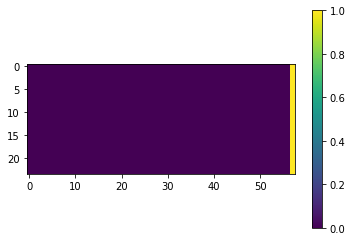

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
야채도 좀 먹어.<eos>      
Mean Loss: 3.9258581698735555
----------------------------------------------------
08-27 00:42:50
Calculated 50 Batches
Loss 50: 3.5416463216145835
08-27 00:43:00


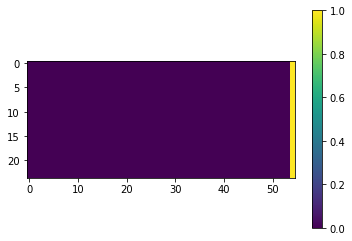

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
슬퍼하지 마세요.<eos>      
Mean Loss: 3.9268948596318562
----------------------------------------------------
08-27 00:43:01
Calculated 50 Batches
Loss 50: 3.5191097259521484
08-27 00:43:12


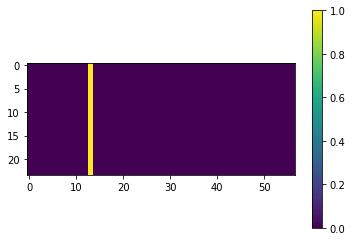

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
중식 좋아하세요?<eos>    
Mean Loss: 3.928359728495279
----------------------------------------------------
08-27 00:43:12
Calculated 50 Batches
Loss 50: 3.5191097259521484
08-27 00:43:23


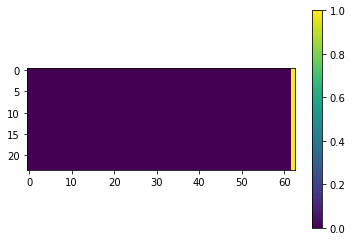

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
왜 도로 오는 거야?<eos>    
Mean Loss: 3.9280667689641318
----------------------------------------------------
08-27 00:43:24
Calculated 50 Batches
Loss 50: 3.586719195048014
08-27 00:43:34


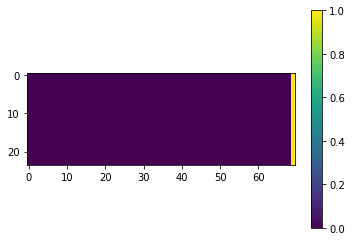

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
언제 데리러 갈까?<eos>    
Mean Loss: 3.927503366788228
----------------------------------------------------
08-27 00:43:35
Calculated 50 Batches
Loss 50: 3.5416463216145835
08-27 00:43:46


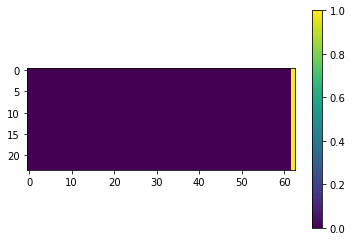

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
너무 기대하지 마.<eos>      
Mean Loss: 3.928494935353598
----------------------------------------------------
08-27 00:43:46
Calculated 50 Batches
Loss 50: 3.6838723887567935
08-27 00:43:57


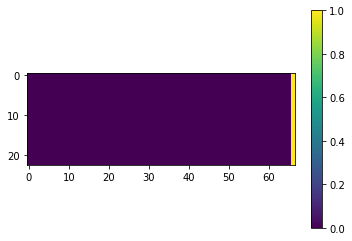

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
헛소리 그만해!<eos>      
Mean Loss: 3.929356258212656
----------------------------------------------------
08-27 00:43:58
Calculated 50 Batches
Loss 50: 3.4515002568562827
08-27 00:44:08


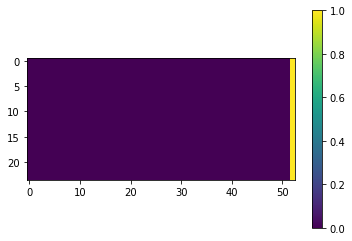

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는 억울해요.<eos>      
Mean Loss: 3.928517488161723
----------------------------------------------------
08-27 00:44:09
Calculated 50 Batches
Loss 50: 3.4289633433024087
08-27 00:44:20


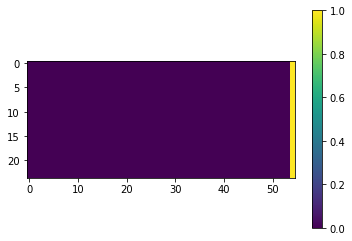

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
왜 그렇게 서둘러?<eos>    
Mean Loss: 3.9268723456064856
----------------------------------------------------
08-27 00:44:20
Calculated 50 Batches
Loss 50: 3.5416460037231445
08-27 00:44:31


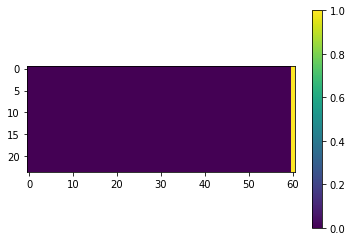

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
전화가 끊겼어요.<eos>    
Mean Loss: 3.931296156582079
----------------------------------------------------
08-27 00:44:32
Calculated 50 Batches
Loss 50: 3.740687283602628
08-27 00:44:42


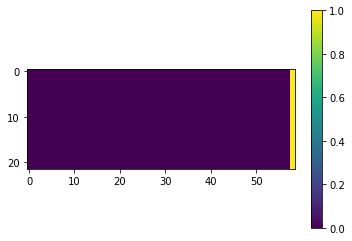

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
논에 벼를 심다<eos>    
Mean Loss: 3.932002463514154
----------------------------------------------------
08-27 00:44:43
Calculated 50 Batches
Loss 50: 3.777565349232067
08-27 00:44:54


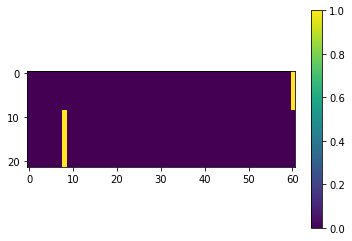

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
배고파 죽겠어요.<eos>   
Mean Loss: 3.9331908047415998
----------------------------------------------------
08-27 00:44:54
Calculated 50 Batches
Loss 50: 3.6133237092391304
08-27 00:45:05


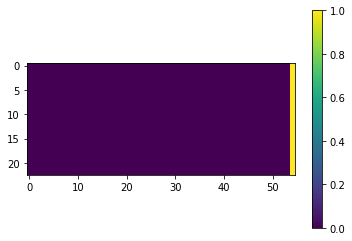

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그림 잘 그리세요?<eos>   
Mean Loss: 3.930334166623544
----------------------------------------------------
08-27 00:45:05
Calculated 50 Batches
Loss 50: 3.6250816013502036
08-27 00:45:16


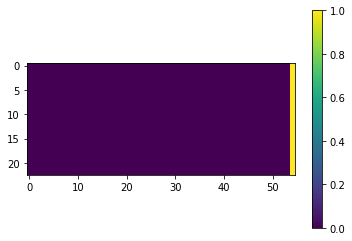

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
관광하러 왔어요.<eos>   
Mean Loss: 3.930614400518114
----------------------------------------------------
08-27 00:45:17
Calculated 50 Batches
Loss 50: 3.6368394934612773
08-27 00:45:28


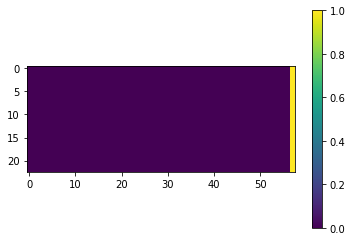

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
예비 열쇠가 있어?<eos>   
Mean Loss: 3.929993148969567
----------------------------------------------------
08-27 00:45:28
Calculated 50 Batches
Loss 50: 3.777565349232067
08-27 00:45:39


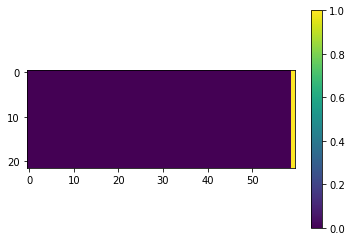

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
흰 셔츠 있나요?<eos>    
Mean Loss: 3.9322893482266057
----------------------------------------------------
08-27 00:45:39
Calculated 50 Batches
Loss 50: 3.4965731302897134
08-27 00:45:50


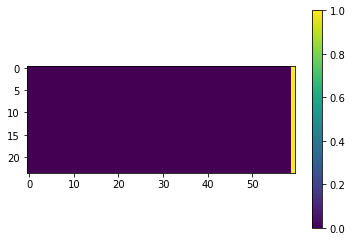

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
배가 진짜 고파요.<eos>     
Mean Loss: 3.930847778671666
----------------------------------------------------
08-27 00:45:51
Calculated 50 Batches
Loss 50: 3.4514999389648438
08-27 00:46:01


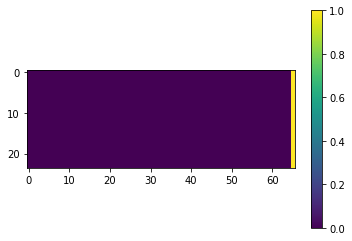

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
술 좀 그만 마셔.<eos>    
Mean Loss: 3.926466640472412
----------------------------------------------------
08-27 00:46:02
Calculated 50 Batches
Loss 50: 3.552914619445801
08-27 00:46:12


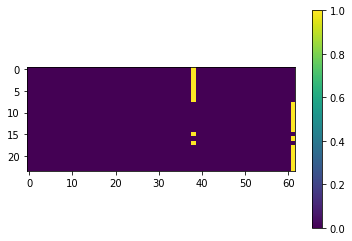

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
햇빛이 눈부셔요.<eos>    
Mean Loss: 3.9268046938578287
----------------------------------------------------
08-27 00:46:13
Calculated 50 Batches
Loss 50: 3.5898069298785664
08-27 00:46:24


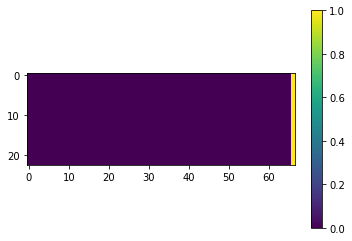

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
내 생각은 이래.<eos>    
Mean Loss: 3.9300666375091104
----------------------------------------------------
08-27 00:46:25
Calculated 50 Batches
Loss 50: 3.5303780237833657
08-27 00:46:35


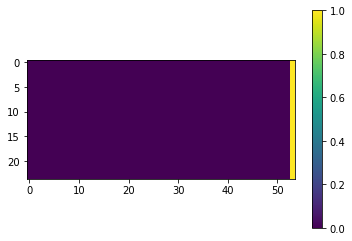

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
잠잘 시간이야.<eos>      
Mean Loss: 3.9275709733963002
----------------------------------------------------
08-27 00:46:36
Calculated 50 Batches
Loss 50: 3.507841428120931
08-27 00:46:46


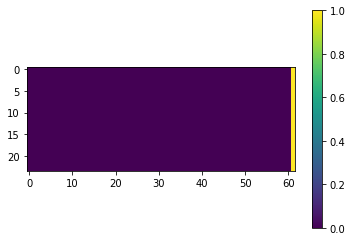

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
짐은 다 쌌어요?<eos>     
Mean Loss: 3.92788648446401
----------------------------------------------------
08-27 00:46:47
Calculated 50 Batches
Loss 50: 3.648598048997962
08-27 00:46:58


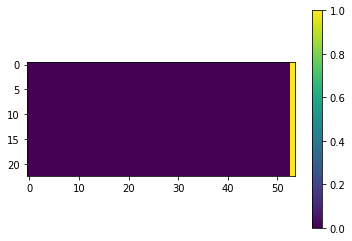

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
총을 쏘지 마세요.<eos>   
Mean Loss: 3.930746707239013
----------------------------------------------------
08-27 00:46:58
Calculated 50 Batches
Loss 50: 3.575451215108236
08-27 00:47:09


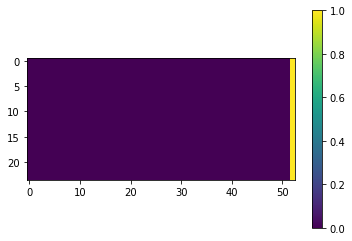

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
총을 쏘지 마세요.<eos>    
Mean Loss: 3.9311253763667326
----------------------------------------------------
08-27 00:47:10
Calculated 50 Batches
Loss 50: 3.4965731302897134
08-27 00:47:21


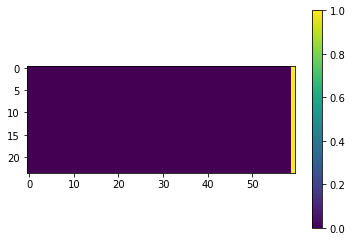

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
제가 알아볼게요.<eos>     
Mean Loss: 3.927863935788472
----------------------------------------------------
08-27 00:47:21
Calculated 50 Batches
Loss 50: 3.4515002568562827
08-27 00:47:32


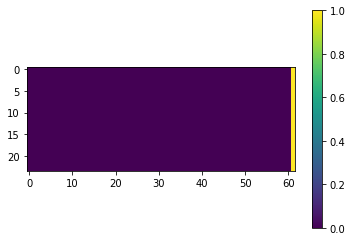

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
논에 벼를 심다<eos>      
Mean Loss: 3.9270976807276408
----------------------------------------------------
08-27 00:47:32
Calculated 50 Batches
Loss 50: 3.552914301554362
08-27 00:47:43


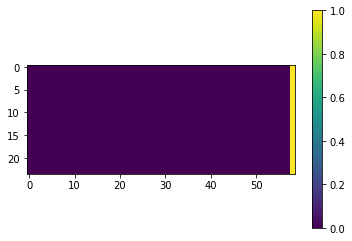

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그대로 놓아두세요.<eos>    
Mean Loss: 3.9273005638122553
----------------------------------------------------
08-27 00:47:43
Calculated 50 Batches
Loss 50: 3.4965731302897134
08-27 00:47:54


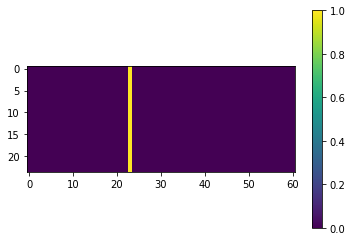

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
통화 중이에요.<eos>       
Mean Loss: 3.927683650652567
----------------------------------------------------
08-27 00:47:55
Calculated 50 Batches
Loss 50: 3.597987492879232
08-27 00:48:06


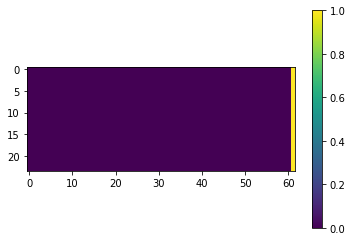

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이게 얼마 만이니?<eos>    
Mean Loss: 3.93172436724211
----------------------------------------------------
08-27 00:48:06
Calculated 50 Batches
Loss 50: 3.485304832458496
08-27 00:48:17


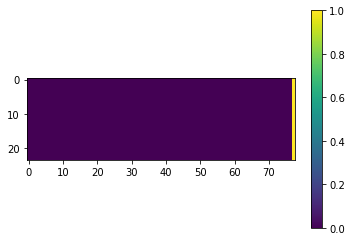

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
최선을 다해라.<eos>       
Mean Loss: 3.927458292643229
----------------------------------------------------
08-27 00:48:17
Calculated 50 Batches
Loss 50: 3.440231959025065
08-27 00:48:28


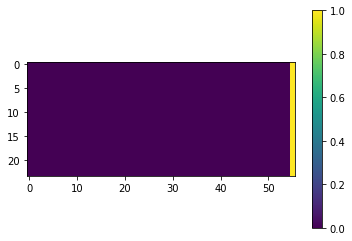

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
정말 맛없다!<eos>       
Mean Loss: 3.928179449081421
----------------------------------------------------
08-27 00:48:28
Calculated 50 Batches
Loss 50: 3.636839825174083
08-27 00:48:39


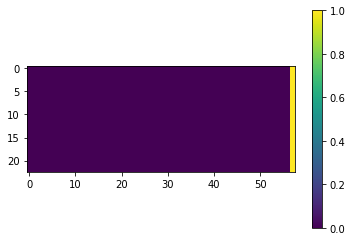

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
좋은 생각이야!<eos>    
Mean Loss: 3.9312552224449484
----------------------------------------------------
08-27 00:48:40
Calculated 50 Batches
Loss 50: 3.552914619445801
08-27 00:48:50


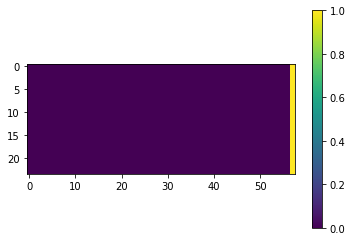

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아버지 도와 드려라.<eos>    
Mean Loss: 3.9271427780787143
----------------------------------------------------
08-27 00:48:51
Calculated 50 Batches
Loss 50: 3.5191097259521484
08-27 00:49:01


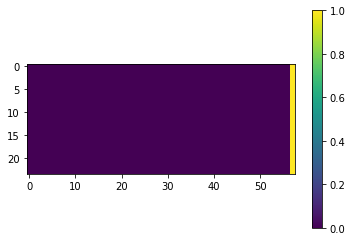

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이것저것 샀어요.<eos>    
Mean Loss: 3.9270525999069217
----------------------------------------------------
08-27 00:49:02
Calculated 50 Batches
Loss 50: 3.4515002568562827
08-27 00:49:12


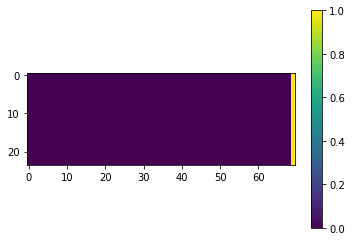

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우리 둘뿐이야.<eos>       
Mean Loss: 3.9312321207816137
----------------------------------------------------
08-27 00:49:13
Calculated 50 Batches
Loss 50: 3.5979878107706704
08-27 00:49:24


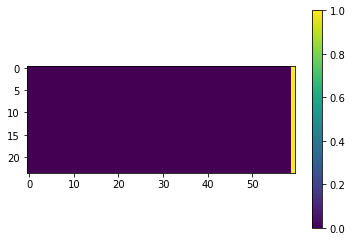

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
즉시 집으로 가라!<eos>    
Mean Loss: 3.927187859535217
----------------------------------------------------
08-27 00:49:24
Calculated 50 Batches
Loss 50: 3.742663507876189
08-27 00:49:35


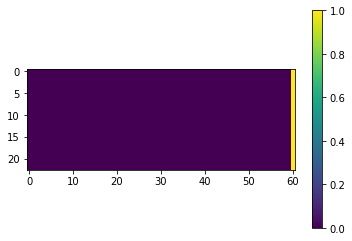

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
오래 기다리셨어요?<eos>   
Mean Loss: 3.9292700439536055
----------------------------------------------------
08-27 00:49:36
Calculated 50 Batches
Loss 50: 3.5416463216145835
08-27 00:49:46


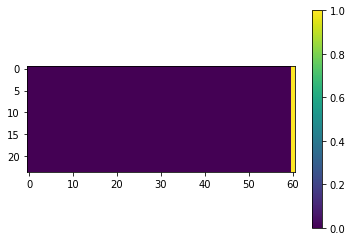

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
더 힘껏 밀어.<eos>       
Mean Loss: 3.9273906386693316
----------------------------------------------------
08-27 00:49:47
Calculated 50 Batches
Loss 50: 3.507841428120931
08-27 00:49:58


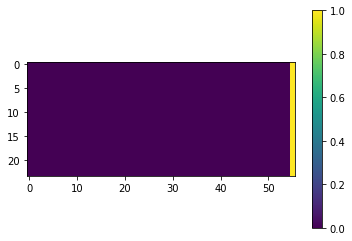

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
오늘이 며칠이죠?<eos>     
Mean Loss: 3.9315476065853185
----------------------------------------------------
08-27 00:49:58
Calculated 50 Batches
Loss 50: 3.5191097259521484
08-27 00:50:09


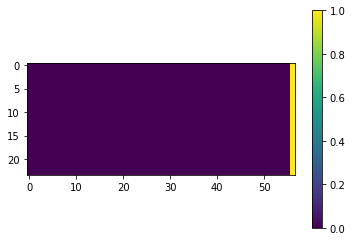

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
제발 좀 서둘러.<eos>     
Mean Loss: 3.9277963199615478
----------------------------------------------------
08-27 00:50:09
Calculated 50 Batches
Loss 50: 3.5303780237833657
08-27 00:50:20


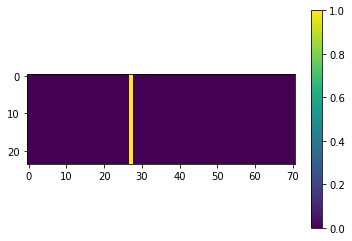

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
내가 어찌 알겠어?<eos>    
Mean Loss: 3.927390688578287
----------------------------------------------------
08-27 00:50:21
Calculated 50 Batches
Loss 50: 3.474036534627279
08-27 00:50:31


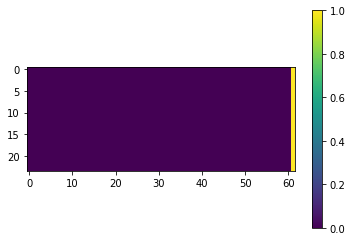

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아이고 깜짝이야.<eos>     
Mean Loss: 3.927458265622457
----------------------------------------------------
08-27 00:50:32
Calculated 50 Batches
Loss 50: 3.485304832458496
08-27 00:50:43


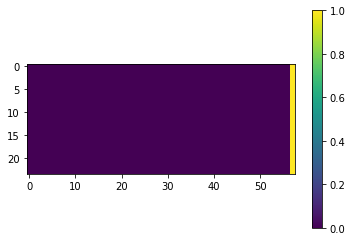

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
안녕히 계세요.<eos>       
Mean Loss: 3.9266694835027063
----------------------------------------------------
08-27 00:50:43
Calculated 50 Batches
Loss 50: 3.6205240885416665
08-27 00:50:54


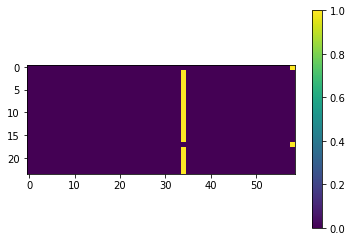

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
쟤는 늘 저래요.<eos>      
Mean Loss: 3.9306319486216488
----------------------------------------------------
08-27 00:50:54
Calculated 50 Batches
Loss 50: 3.5303780237833657
08-27 00:51:05


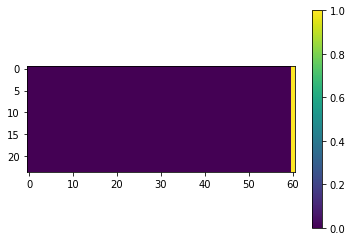

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
부산국제영화제<eos>      
Mean Loss: 3.9264216273625694
----------------------------------------------------
08-27 00:51:06
Calculated 50 Batches
Loss 50: 3.586719195048014
08-27 00:51:16


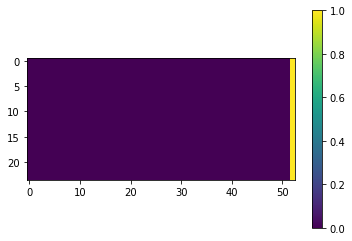

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
대사는 다 외웠어?<eos>    
Mean Loss: 3.9269174133936557
----------------------------------------------------
08-27 00:51:17
Calculated 50 Batches
Loss 50: 3.5641825993855796
08-27 00:51:27


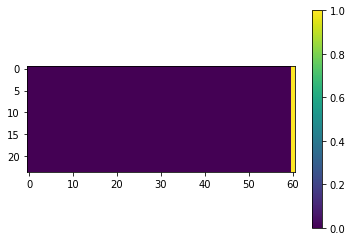

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
행운을 빌어.<eos>       
Mean Loss: 3.930299815428885
----------------------------------------------------
08-27 00:51:28
Calculated 50 Batches
Loss 50: 3.552914301554362
08-27 00:51:39


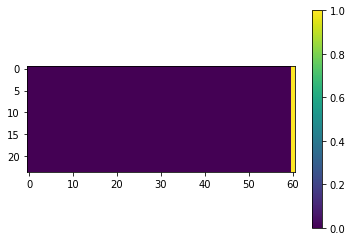

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
엄마 집에 계셔?<eos>      
Mean Loss: 3.927232918421427
----------------------------------------------------
08-27 00:51:39
Calculated 50 Batches
Loss 50: 3.597987492879232
08-27 00:51:50


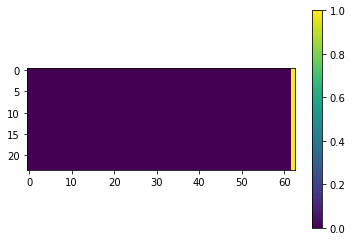

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
총을 쏘지 마세요.<eos>    
Mean Loss: 3.9280892817179365
----------------------------------------------------
08-27 00:51:51
Calculated 50 Batches
Loss 50: 3.6205240885416665
08-27 00:52:01


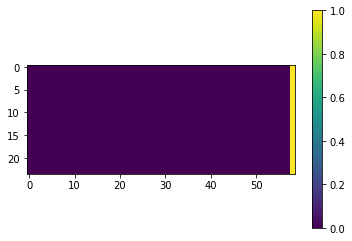

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
나눠서 계산하자.<eos>      
Mean Loss: 3.927097675641378
----------------------------------------------------
08-27 00:52:02
Calculated 50 Batches
Loss 50: 3.485304832458496
08-27 00:52:13


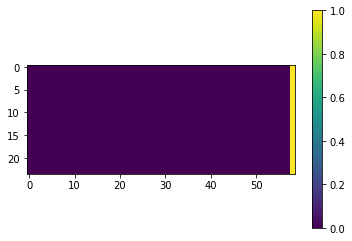

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
거의 다 됐어요.<eos>       
Mean Loss: 3.927683654785156
----------------------------------------------------
08-27 00:52:13
Calculated 50 Batches
Loss 50: 3.554532590119735
08-27 00:52:24


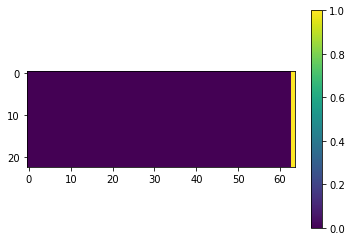

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
약간 비싼데요.<eos>     
Mean Loss: 3.9299471441628278
----------------------------------------------------
08-27 00:52:24
Calculated 50 Batches
Loss 50: 3.586719195048014
08-27 00:52:35


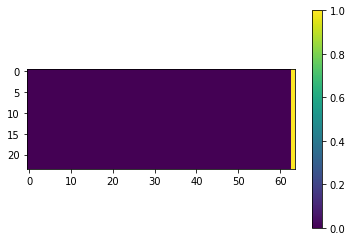

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
내 뒤에 서 있어라.<eos>    
Mean Loss: 3.9277512337366733
----------------------------------------------------
08-27 00:52:36
Calculated 50 Batches
Loss 50: 3.485304832458496
08-27 00:52:46


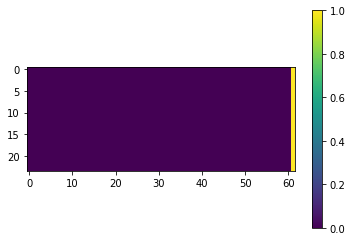

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
연필 다섯 자루<eos>      
Mean Loss: 3.9266469287872314
----------------------------------------------------
08-27 00:52:47
Calculated 50 Batches
Loss 50: 3.4740368525187173
08-27 00:52:58


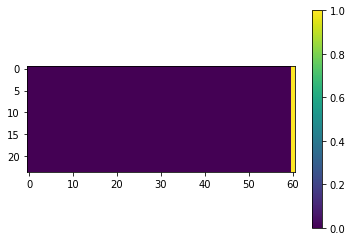

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
잠시 쉬지 그래?<eos>       
Mean Loss: 3.928337230682373
----------------------------------------------------
08-27 00:52:58
Calculated 50 Batches
Loss 50: 3.636839825174083
08-27 00:53:09


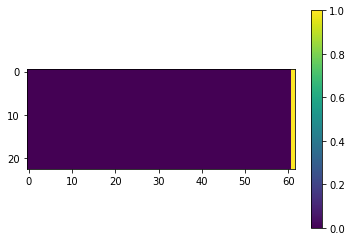

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
햇빛이 눈부셔요.<eos>   
Mean Loss: 3.9300607685697253
----------------------------------------------------
08-27 00:53:09
Calculated 50 Batches
Loss 50: 3.5191097259521484
08-27 00:53:20


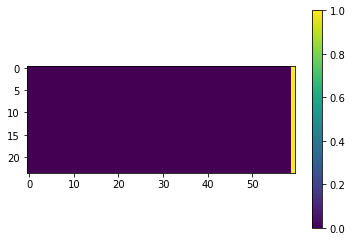

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그게 무슨 소리야?<eos>     
Mean Loss: 3.926444128036499
----------------------------------------------------
08-27 00:53:21
Calculated 50 Batches
Loss 50: 3.5303777058919272
08-27 00:53:31


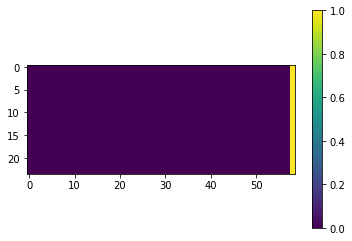

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
움직이지 마세요.<eos>     
Mean Loss: 3.9273455613454185
----------------------------------------------------
08-27 00:53:32
Calculated 50 Batches
Loss 50: 3.597987492879232
08-27 00:53:43


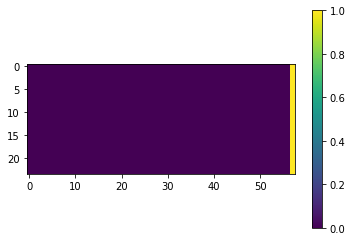

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
염려하지 마세요.<eos>      
Mean Loss: 3.9267821604410806
----------------------------------------------------
08-27 00:53:44
Calculated 50 Batches
Loss 50: 3.5303780237833657
08-27 00:53:54


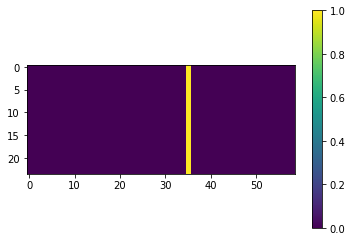

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
부산국제영화제<eos>      
Mean Loss: 3.9331500622933375
----------------------------------------------------
08-27 00:53:55
Calculated 50 Batches
Loss 50: 3.578049037767493
08-27 00:54:05


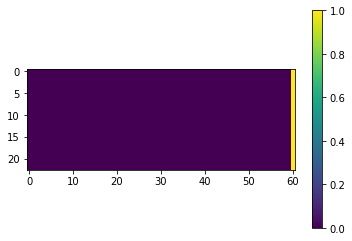

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그대로 놓아두세요.<eos>   
Mean Loss: 3.9299442074678943
----------------------------------------------------
08-27 00:54:06
Calculated 50 Batches
Loss 50: 3.597987492879232
08-27 00:54:17


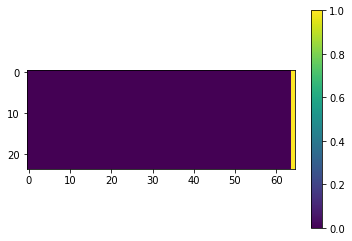

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
뭐 때문에 싸웠어?<eos>    
Mean Loss: 3.9282695891062422
----------------------------------------------------
08-27 00:54:17
Calculated 50 Batches
Loss 50: 3.552914301554362
08-27 00:54:28


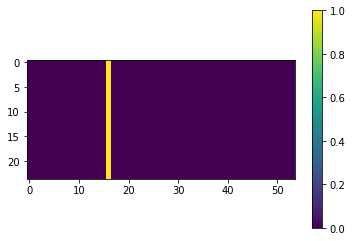

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
바둑 한 판 어때?<eos>    
Mean Loss: 3.926061018308003
----------------------------------------------------
08-27 00:54:29
Calculated 50 Batches
Loss 50: 3.5416463216145835
08-27 00:54:39


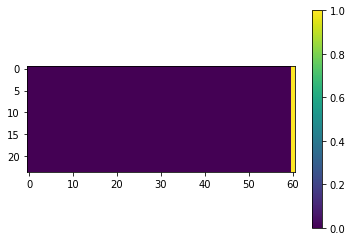

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
일 좀 제대로 해!<eos>     
Mean Loss: 3.9307161369825665
----------------------------------------------------
08-27 00:54:40
Calculated 50 Batches
Loss 50: 3.597987492879232
08-27 00:54:51


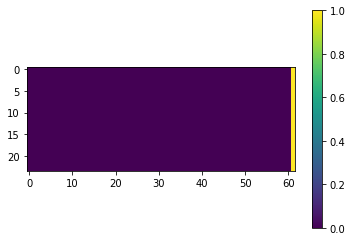

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
무사해서 다행이야.<eos>    
Mean Loss: 3.9306663167016547
----------------------------------------------------
08-27 00:54:52
Calculated 50 Batches
Loss 50: 3.648598048997962
08-27 00:55:02


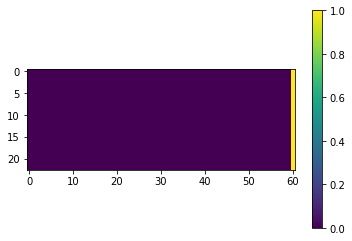

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
내 옷 어디 있지?<eos>    
Mean Loss: 3.9297550582471104
----------------------------------------------------
08-27 00:55:03
Calculated 50 Batches
Loss 50: 3.507841428120931
08-27 00:55:14


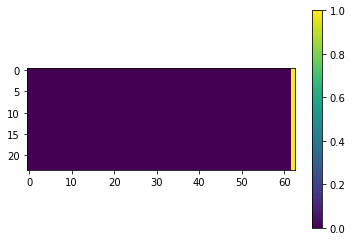

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저를 잊지 마세요.<eos>    
Mean Loss: 3.9291485163370776
----------------------------------------------------
08-27 00:55:14
Calculated 50 Batches
Loss 50: 3.609255790710449
08-27 00:55:25


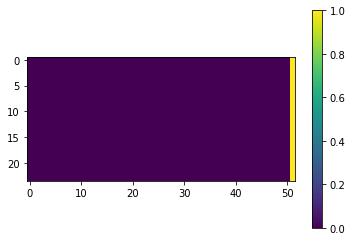

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
침묵은 금이다.<eos>     
Mean Loss: 3.9265117171605426
----------------------------------------------------
08-27 00:55:25
Calculated 50 Batches
Loss 50: 3.5303780237833657
08-27 00:55:36


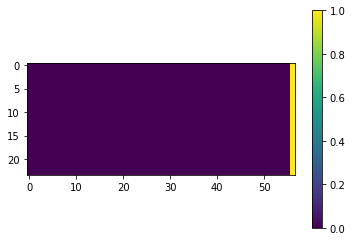

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
늦어서 미안해.<eos>       
Mean Loss: 3.927909031867981
----------------------------------------------------
08-27 00:55:37
Calculated 50 Batches
Loss 50: 3.5416463216145835
08-27 00:55:47


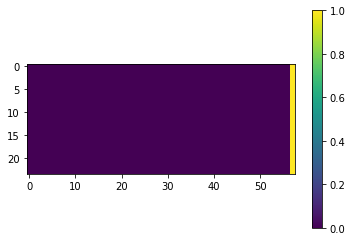

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
국이 좀 싱겁네.<eos>    
Mean Loss: 3.9278639418284103
----------------------------------------------------
08-27 00:55:48
Calculated 50 Batches
Loss 50: 3.6250816013502036
08-27 00:55:59


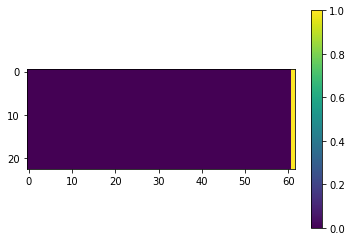

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
네 생각은 어때?<eos>    
Mean Loss: 3.932695639298219
----------------------------------------------------
08-27 00:55:59
Calculated 50 Batches
Loss 50: 3.683872720469599
08-27 00:56:10


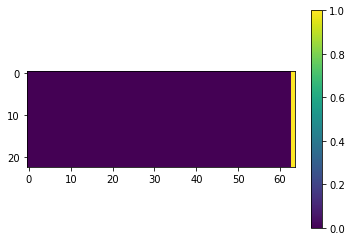

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
거기 누구 있어요?<eos>    
Mean Loss: 3.9298971803361087
----------------------------------------------------
08-27 00:56:11
Calculated 50 Batches
Loss 50: 3.660356272821841
08-27 00:56:21


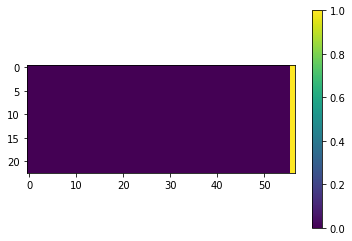

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
잘 좀 찾아봐.<eos>      
Mean Loss: 3.9313424353115805
----------------------------------------------------
08-27 00:56:22
Calculated 50 Batches
Loss 50: 3.648598048997962
08-27 00:56:33


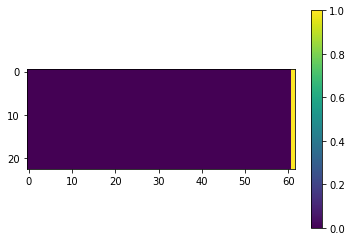

<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
미리 알려 주세요.<eos>    
Mean Loss: 3.931625640509785
----------------------------------------------------


In [21]:
EPOCH = 100
REPEAT = 1

for epoch in range(EPOCH):
    try:
         net.load('check_point_test_conv')
    except:
        print("Loading Error")
    preloader.initialize_batch()
    counter = 0
    loss_list = list()
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    while preloader.end_flag == False:
        tensor_input, ground_truth, loss_mask = preloader.get_batch()
        
        for i in range(REPEAT):
            pred_tensor, attention_matrix, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device))
        
        counter += 1
        loss_list.append(loss)
        
        if (counter % 50 == 0):
            print('Calculated {} Batches'.format(counter))
            print('Loss {}: {}'.format(counter, loss))
            print(datetime.now().strftime('%m-%d %H:%M:%S'))

            plt.figure()
            plt.imshow(attention_matrix[0].detach().cpu().numpy())
            plt.colorbar()
            plt.show()
            _, index = pred_tensor[0].max(-1)
            sentence = tokenizer.num2word(index.view(-1))
            print(''.join(sentence))
            true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
            print(''.join(true_sentence))
            
        if counter == 50:
            break
            
    net.save('check_point_test_conv')
    print("Mean Loss: {}".format(np.mean(np.asarray(loss_list))))
    print("----------------------------------------------------")

In [ ]:
# EPOCH = 1

# for epoch in range(EPOCH):
    
#     net.load('check_point_test')
    
#     for i in tqdm(range(len(metadata))):
#         tensor_input = preloader.get(i)
#         ground_truth = ground_truth_list[i]
        
#         pred_tensor, attention_matrix, loss = net.train(tensor_input.to(device), ground_truth.to(device))
        
#         if (i % 100 == 0):
#             print(datetime.datetime.now())
#             print('Loss {}: {}'.format(i, loss))
#             plt.figure()
#             plt.imshow(attention_matrix[0].detach().cpu().numpy())
#             plt.colorbar()
#             plt.show()
#             _, index = pred_tensor.max(-1)
#             sentence = tokenizer.num2word(index.view(-1))
#             print(''.join(sentence))
#             print(metadata[i, 2])
    
#     net.save('check_point_test')

In [ ]:
# plt.figure()
# plt.imshow(attention_matrix[0].detach().cpu().numpy())
# plt.colorbar()
# plt.show()

In [ ]:
# print(attention_matrix[0, 0, :].shape)
# print(sum(attention_matrix[0, 0, :]))

In [ ]:
# net.save('check_point_test')

In [ ]:
# net.load('check_point_test')